In [45]:
source("../../BrusselSprouts/scripts/functions.R")

Warning message in file(filename, "r", encoding = encoding):
"cannot open file '../../BrusselSprouts/scripts/functions.R': No such file or directory"


ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [23]:
fastq_dir="/home/jnrunge/data/trd/my_sequences/"

In [24]:
reference="/home/jnrunge/data/TRD/R64_nucl.fasta"

In [25]:
scripts_dir="/home/jnrunge/data/trd/mapped_reads/scripts/"

In [26]:
fastq_files=list.files(path=fastq_dir,pattern="txt.gz")
fastq_files

[1] "AACHK3JM5_RTG_EX_2_23s000033-1-1_Schacherer_lane1JF3x1_1_sequence.txt.gz"
[2] "AACHK3JM5_RTG_EX_2_23s000033-1-1_Schacherer_lane1JF3x1_2_sequence.txt.gz"
[3] "AACHK3JM5_RTG_EX_2_23s000033-1-1_Schacherer_lane1JF4_1_sequence.txt.gz"  
[4] "AACHK3JM5_RTG_EX_2_23s000033-1-1_Schacherer_lane1JF4_2_sequence.txt.gz"  
[5] "AACHK3JM5_RTG_EX_2_23s000033-1-1_Schacherer_lane1JG4_1_sequence.txt.gz"  
[6] "AACHK3JM5_RTG_EX_2_23s000033-1-1_Schacherer_lane1JG4_2_sequence.txt.gz"

In [27]:
trimmed_files=list.files(path=paste0(fastq_dir, "trim_galore"),pattern="fq.gz$")
trimmed_files

[1] "AACHK3JM5_RTG_EX_2_23s000033-1-1_Schacherer_lane1JF3x1_1_sequence.txt.gz_val_1.fq.gz"
[2] "AACHK3JM5_RTG_EX_2_23s000033-1-1_Schacherer_lane1JF3x1_2_sequence.txt.gz_val_2.fq.gz"
[3] "AACHK3JM5_RTG_EX_2_23s000033-1-1_Schacherer_lane1JF4_1_sequence.txt.gz_val_1.fq.gz"  
[4] "AACHK3JM5_RTG_EX_2_23s000033-1-1_Schacherer_lane1JF4_2_sequence.txt.gz_val_2.fq.gz"  
[5] "AACHK3JM5_RTG_EX_2_23s000033-1-1_Schacherer_lane1JG4_1_sequence.txt.gz_val_1.fq.gz"  
[6] "AACHK3JM5_RTG_EX_2_23s000033-1-1_Schacherer_lane1JG4_2_sequence.txt.gz_val_2.fq.gz"

In [28]:
# if >= 1 missing trimmed file

if(length(fastq_files)!=length(trimmed_files))
    {
    cmd=paste0("cd ", fastq_dir, " && trim_galore --paired -o trim_galore -j 10 *gz")
    execute_cmd_sbatch(cmd, mem="8gb", cpu="10", time="long", env="bwaetc", jobname="trim_galore")
}

In [29]:
# fastqc on trimmed files

for(f in trimmed_files){
    if(file.exists(paste0(fastq_dir,"trim_galore/fastqc/",
                         str_replace(f,fixed(".fq.gz"),"_fastqc.html")))){
        next
    }
    cmd=paste0("cd ",fastq_dir,"trim_galore && fastqc -o fastqc -t 1 -d . ",f,"")
    execute_cmd_sbatch(cmd, mem="4gb", cpu="1", time="short", env="bwaetc", jobname = "FastQC")
    Sys.sleep(1)
}

In [30]:
# need to find a smart way of getting sensible IDs

IDs=unlist(lapply(unlist(lapply(trimmed_files, getWhich, which=1, fixed=FALSE, split="[_][0-9][_][s]")), getWhich, which=2, split="lane1"))
IDs

[1] "JF3x1" "JF3x1" "JF4"   "JF4"   "JG4"   "JG4"

In [31]:
df=data.frame(ID=IDs, file=trimmed_files)
if(nrow(df)%%2 != 0){
    stop("missing files!")
}

In [32]:
# this expects 2x75
# needs to include the length detection script from BrusselSprouts

In [38]:
initial_timedate=Sys.time()

In [39]:
for(ID in unique(df$ID)){
    print(ID)
    
    if(file.exists(paste0("~/data/trd/mapped_reads/",ID,".m.sort.markdup.bam"))){
        next
    }
    
    
    cmd=paste0("cd ",fastq_dir,"trim_galore
bwa mem -t 5 -M -T 0 -a ",reference," ",df$file[df$ID==ID][1], " ",df$file[df$ID==ID][2], " > ~/data/trd/mapped_reads/",ID,".sam
samtools sort -n -m 800M -@ 5 -O BAM -o ~/data/trd/mapped_reads/",ID,".bam ~/data/trd/mapped_reads/",ID,".sam
rm -f ~/data/trd/mapped_reads/",ID,".sam
samtools fixmate -@ 5 -m ~/data/trd/mapped_reads/",ID,".bam ~/data/trd/mapped_reads/",ID,".m.bam
rm -f ~/data/trd/mapped_reads/",ID,".bam
samtools sort -m 800M -@ 5 -O bam -o ~/data/trd/mapped_reads/",ID,".m.sort.bam  ~/data/trd/mapped_reads/",ID,".m.bam 
rm -f ~/data/trd/mapped_reads/",ID,".m.bam
samtools markdup -l 75 -s -@ 5 ~/data/trd/mapped_reads/",ID,".m.sort.bam ~/data/trd/mapped_reads/",ID,".m.sort.markdup.bam
rm -f ~/data/trd/mapped_reads/",ID,".m.sort.bam 
samtools index ~/data/trd/mapped_reads/",ID,".m.sort.markdup.bam")
               
    sbatch_list=execute_complex_sbatch(cmd, jobname = "BWA", scripts_dir = scripts_dir, uniqueRunID = ID, cores="5", mem="5gb", time="short", env="bwaetc", initial_timedate = initial_timedate, jobs_simul = 10, jobs_total = 10)

}

[1] "JF3x1"
[1] "/home/jnrunge/data/trd/mapped_reads/scripts/BWA-JF3x1.sbatch"
[1] "JF4"
[1] "/home/jnrunge/data/trd/mapped_reads/scripts/BWA-JF4.sbatch"
[1] "JG4"
[1] "/home/jnrunge/data/trd/mapped_reads/scripts/BWA-JG4.sbatch"


In [40]:
if(exists("sbatch_list")){
    start_sbatch_list(sbatch_list, 10, "BWA", initial_timedate)
    }

[1] "3 /home/jnrunge/data/trd/mapped_reads/scripts/BWA.list"
[1] "[1] \"Currently running 0 jobs.\""               
[2] "[1] \"3 sbatches remaining! Running 11 more...\""
[3] "[1] \"Submitted batch job 460730\""              
[4] "[1] \"Submitted batch job 460731\""              
[5] "[1] \"Submitted batch job 460732\""              


In [41]:
bam_files=list.files(path="~/data/trd/mapped_reads",pattern="markdup.bam$",full.names = TRUE)
bam_files=bam_files[!grepl("tmp",bam_files,fixed = TRUE)]
bam_files

[1] "/home/jnrunge/data/trd/mapped_reads/JF3x1.m.sort.markdup.bam"
[2] "/home/jnrunge/data/trd/mapped_reads/JF4.m.sort.markdup.bam"  
[3] "/home/jnrunge/data/trd/mapped_reads/JG4.m.sort.markdup.bam"

In [42]:
for(b in bam_files){
    if(file.exists(paste0(b,".mq.tmp.tsv.gz","-windows.tsv.gz"))){
        next
    }
    cmd=paste0("samtools view ",b," | cut -f 3,4,5 | gzip > ",b,".mq.tmp.tsv.gz")
    cmd=paste0(cmd,"
","conda activate JupyteR4 && Rscript ", "/home/jnrunge/TRD/01_Mapping/01_Mapping-MQ-windows.r ", b,".mq.tmp.tsv.gz")
    cmd=paste0(cmd,"
rm -f ",b,".mq.tmp.tsv.gz")
    print(cmd)
    
    sbatch_list=execute_complex_sbatch(cmd, jobname = "MQ-QC", scripts_dir = scripts_dir, uniqueRunID = basename(b), cores="1", mem="5gb", time="short", env="bwaetc", initial_timedate = initial_timedate, jobs_simul = 10, jobs_total = 10)
}
print(sbatch_list)
start_sbatch_list(sbatch_list, 10, "MQ-QC", initial_timedate)

[1] "samtools view /home/jnrunge/data/trd/mapped_reads/JF3x1.m.sort.markdup.bam | cut -f 3,4,5 | gzip > /home/jnrunge/data/trd/mapped_reads/JF3x1.m.sort.markdup.bam.mq.tmp.tsv.gz\nconda activate JupyteR4 && Rscript /home/jnrunge/TRD/01_Mapping/01_Mapping-MQ-windows.r /home/jnrunge/data/trd/mapped_reads/JF3x1.m.sort.markdup.bam.mq.tmp.tsv.gz\nrm -f /home/jnrunge/data/trd/mapped_reads/JF3x1.m.sort.markdup.bam.mq.tmp.tsv.gz"
[1] "/home/jnrunge/data/trd/mapped_reads/scripts/MQ-QC-JF3x1.m.sort.markdup.bam.sbatch"
[1] "samtools view /home/jnrunge/data/trd/mapped_reads/JF4.m.sort.markdup.bam | cut -f 3,4,5 | gzip > /home/jnrunge/data/trd/mapped_reads/JF4.m.sort.markdup.bam.mq.tmp.tsv.gz\nconda activate JupyteR4 && Rscript /home/jnrunge/TRD/01_Mapping/01_Mapping-MQ-windows.r /home/jnrunge/data/trd/mapped_reads/JF4.m.sort.markdup.bam.mq.tmp.tsv.gz\nrm -f /home/jnrunge/data/trd/mapped_reads/JF4.m.sort.markdup.bam.mq.tmp.tsv.gz"
[1] "/home/jnrunge/data/trd/mapped_reads/scripts/MQ-QC-JF4.m.sort.ma

In [46]:
MQ_files=list.files(path="~/data/trd/mapped_reads",pattern="-windows.tsv.gz$",full.names = TRUE)
MQ_files

[1] "/home/jnrunge/data/trd/mapped_reads/JF3x1.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz"
[2] "/home/jnrunge/data/trd/mapped_reads/JF4.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz"  
[3] "/home/jnrunge/data/trd/mapped_reads/JG4.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz"

In [47]:
MQ_df=fread_and_bind_files(MQ_files)
chrs=summarise(group_by(MQ_df, chr),maxPos=max(pos))
MQ_df$global_pos=MQ_df$pos
for(c in 2:length(unique(MQ_df$chr))){
    chr=unique(MQ_df$chr)[c]
    MQ_df$global_pos[MQ_df$chr==chr]=MQ_df$pos[MQ_df$chr==chr]+sum(chrs$maxPos[chrs$chr%in%unique(MQ_df$chr)[1:(c-1)]])
}
head(MQ_df)

,chr,pos,meanMQ,n,file,global_pos
,<chr>,<int>,<dbl>,<int>,<chr>,<int>
1,chromosome1,10023,45.44490,490,/home/jnrunge/data/trd/mapped_reads/JF3x1.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz,10023
2,chromosome1,20023,42.63129,556,/home/jnrunge/data/trd/mapped_reads/JF3x1.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz,20023
3,chromosome1,30023,49.19466,637,/home/jnrunge/data/trd/mapped_reads/JF3x1.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz,30023
4,chromosome1,40023,59.82609,1426,/home/jnrunge/data/trd/mapped_reads/JF3x1.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz,40023
5,chromosome1,50023,59.08831,1608,/home/jnrunge/data/trd/mapped_reads/JF3x1.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz,50023
6,chromosome1,60023,59.82152,1608,/home/jnrunge/data/trd/mapped_reads/JF3x1.m.sort.markdup.bam.mq.tmp.tsv.gz-windows.tsv.gz,60023


In [48]:
MQ_df$ID=unlist(lapply(basename(MQ_df$file), getFirst_v2, split="."))

Warning message:
"Removed 46 rows containing missing values (`geom_point()`)."


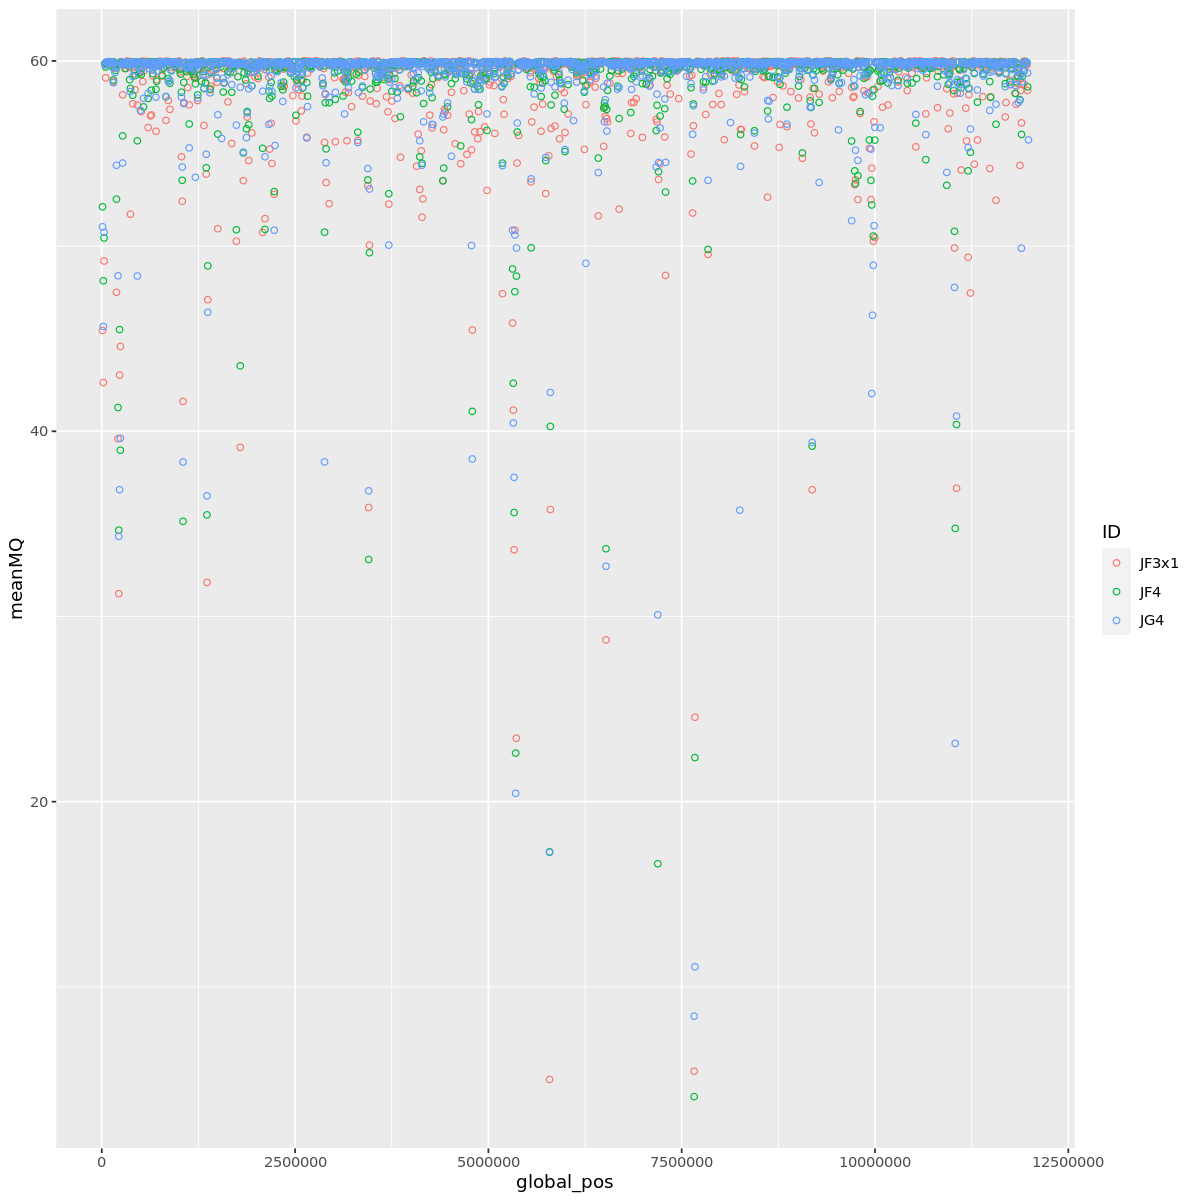

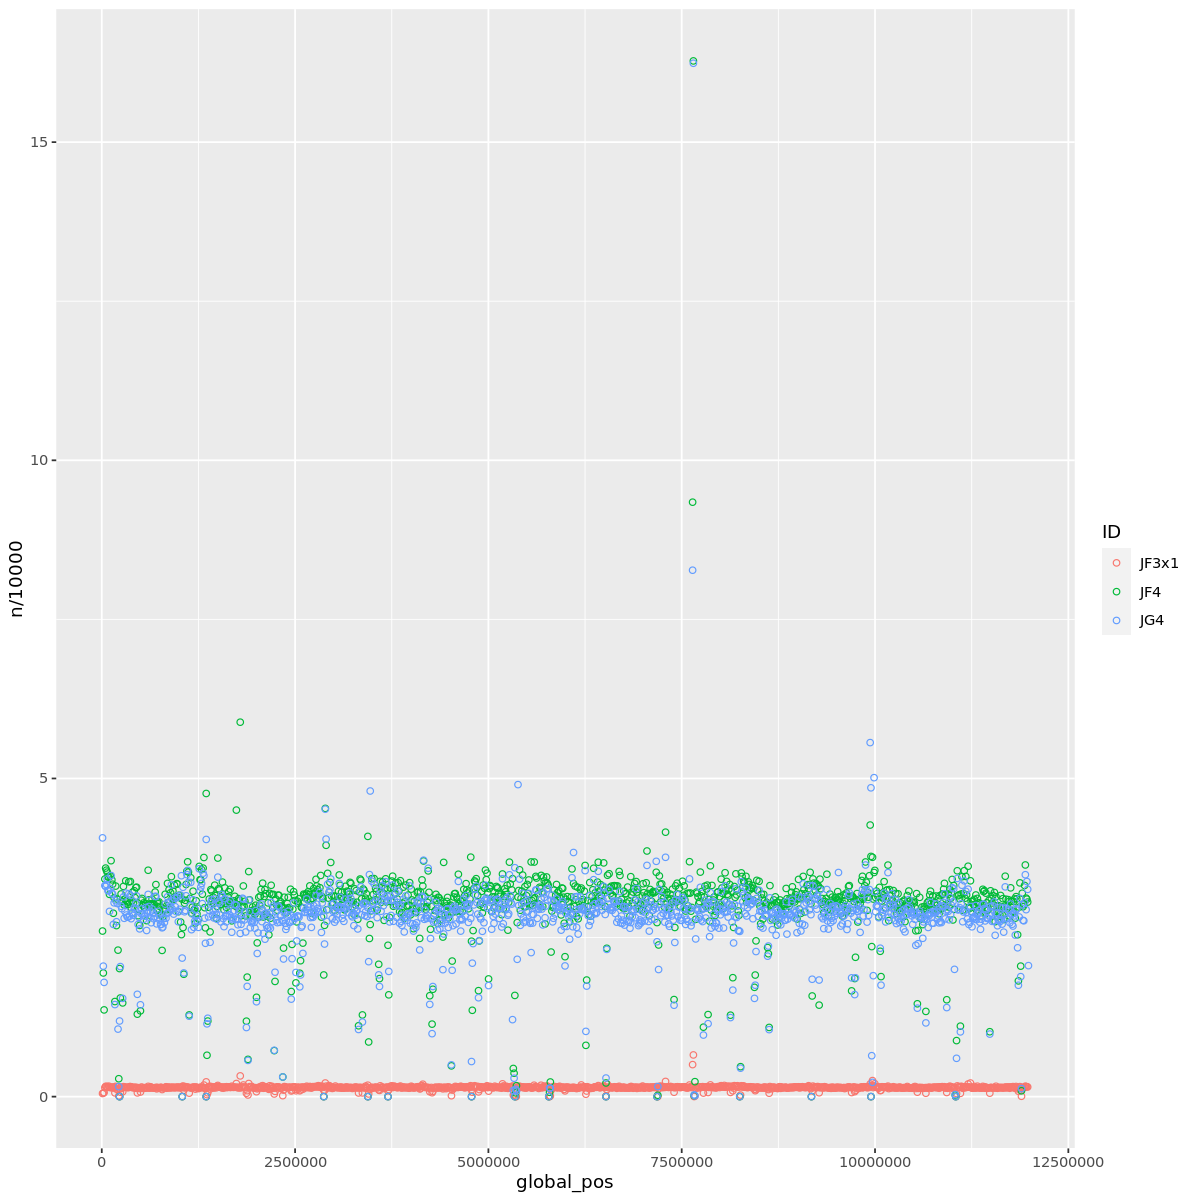

In [49]:
library(ggplot2)
ggplot(MQ_df, aes(global_pos, meanMQ, color=ID))+
geom_point(shape=1)
ggplot(MQ_df, aes(global_pos, n/10000, color=ID))+
geom_point(shape=1)

In [44]:
# finally, rename BAMs
# need to add sequencing names to Crosses.xlsx
# for the moment:

renaming=data.frame(fastq=NA,bam=basename(bam_files),Jname=NA)
renaming$Jname=c("YJNRC2.bam","YJNRC17.bam","YJNRC18.bam")
renaming
setwd(dirname(bam_files[1]))
for(i in 1:nrow(renaming)){
    cmd=paste0("ln -sf ",renaming$bam[i]," ",renaming$Jname[i])
    print(cmd)
    print(system(command=cmd,intern=TRUE))
    cmd=paste0("ln -sf ",renaming$bam[i],".bai ",renaming$Jname[i],".bai")
    print(cmd)
    print(system(command=cmd,intern=TRUE))
}

fastq,bam,Jname
<lgl>,<chr>,<chr>
NA,JF3x1.m.sort.markdup.bam,YJNRC2.bam
NA,JF4.m.sort.markdup.bam,YJNRC17.bam
NA,JG4.m.sort.markdup.bam,YJNRC18.bam


[1] "ln -sf JF3x1.m.sort.markdup.bam YJNRC2.bam"
character(0)
[1] "ln -sf JF3x1.m.sort.markdup.bam.bai YJNRC2.bam.bai"
character(0)
[1] "ln -sf JF4.m.sort.markdup.bam YJNRC17.bam"
character(0)
[1] "ln -sf JF4.m.sort.markdup.bam.bai YJNRC17.bam.bai"
character(0)
[1] "ln -sf JG4.m.sort.markdup.bam YJNRC18.bam"
character(0)
[1] "ln -sf JG4.m.sort.markdup.bam.bai YJNRC18.bam.bai"
character(0)
